In [1]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
import numpy as np
# Classification
from sklearn.metrics import balanced_accuracy_score, average_precision_score, roc_auc_score, f1_score, recall_score, precision_score, classification_report
from sklearn.metrics import brier_score_loss

In [2]:
PAT = '/Users/marinacamacho/Desktop/Master_I/Data_Final'
DIS = "Depression_1"
MOD = "Binary_1"
FET = "45" 

In [3]:
with open(f"{PAT}/{MOD}/fitted_models_{DIS}{FET}", "rb") as fp:
    models = pickle.load(fp)

In [4]:
PAT = '/Users/marinacamacho/Desktop/Master_I/Data_Final'
DIS = "Diabetes_Depression_2"
MOD = "Binary_2"
FET = "45"

In [5]:
# Read trainCohort_{DIS} file
with open(f"{PAT}/trainCohort_{DIS}", "rb") as fp:
    trainData = pickle.load(fp)
# Read trainLabels_{DIS} file
with open(f"{PAT}/trainLabels_{DIS}", "rb") as fp:
    y_train = pickle.load(fp)

# Read externalCohort_{DIS} file
with open(f"{PAT}/externalCohort_{DIS}", "rb") as fp:
    extCohort = pickle.load(fp)
# Read externalLabels_{DIS} file
with open(f"{PAT}/externalLabels_{DIS}", "rb") as fp:
    y_ext = pickle.load(fp)

# Read traceCohort_{DIS} file
with open(f"{PAT}/traceCohort_{DIS}", "rb") as fp:
    traceCohort = pickle.load(fp)
# Read traceLabels_{DIS} file
with open(f"{PAT}/traceLabels_{DIS}", "rb") as fp:
    y_trace = pickle.load(fp)

In [6]:
extCohort['PastDiabetes'] = 1
traceCohort['PastDiabetes'] = 1
trainData['PastDiabetes'] = 1

In [7]:
X_ext = extCohort.values
X_trace = traceCohort.values
X_train = trainData.values

In [8]:
# Sample datasets for demonstration
# Replace these with your actual datasets
dataset0_X, dataset0_y = X_train, y_train
dataset1_X, dataset1_y = X_ext, y_ext
dataset2_X, dataset2_y = X_trace, y_trace

results = {
    "Model": [],
    "Dataset": [],
    "Precision": [],
    "Recall": [],
    "F1-Score": [],
    "Balanced Accuracy": [],   # Add this line for Balanced Accuracy
}

for model_name, model_variants in models.items():
    for variant, model_info in model_variants.items():
        pipeline = model_info['model']
        threshold = model_info['threshold']
        
        #for dataset_name, (X, y) in [('Training set', (dataset0_X, dataset0_y)),('External set I', (dataset1_X, dataset1_y)), ('External set II', (dataset2_X, dataset2_y))]:
        for dataset_name, (X, y) in [('External set I', (dataset1_X, dataset1_y)), ('External set II', (dataset2_X, dataset2_y))]:
            # Obtain probabilities and predict based on the threshold
            y_prob = pipeline.predict_proba(X)[:, 1]
            y_pred = [1 if prob > threshold else 0 for prob in y_prob]

            report = classification_report(y, y_pred, output_dict=True, zero_division=0)

            # Balanced Accuracy
            bal_acc = balanced_accuracy_score(y, y_pred)

            # Assuming a binary classification, you can adjust as per your classes
            average_results = report['weighted avg']

            results["Model"].append(f"{model_name}_{variant}")
            results["Dataset"].append(dataset_name)
            results["Precision"].append(average_results['precision'])
            results["Recall"].append(average_results['recall'])
            results["F1-Score"].append(average_results['f1-score'])
            results["Balanced Accuracy"].append(bal_acc)  # Add this line to store Balanced Accuracy

df = pd.DataFrame(results)

# Display without truncation
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid featur

In [9]:
# Find the best model for Dataset1 based on F1-Score
best_model_idx_dataset1 = df[df['Dataset'] == 'External set I']['F1-Score'].idxmax()
best_model_info_dataset1 = df.loc[best_model_idx_dataset1]

print("Best Model for Dataset1 based on F1-Score:")
print(best_model_info_dataset1)
print("\n")  # just to create a gap between outputs

Best Model for Dataset1 based on F1-Score:
Model                XGB_3         
Dataset              External set I
Precision            0.83855       
Recall               0.8781        
F1-Score             0.846628      
Balanced Accuracy    0.548643      
Name: 26, dtype: object




In [10]:
best_model = models[best_model_info_dataset1[0][:-2]][int(best_model_info_dataset1[0][-1:])]
best_feats = trainData.iloc[:,best_model['features']].columns

probs = best_model['model'].predict_proba(X_ext)[:,1]
preds = np.where(probs > best_model['threshold'], 1, 0)
print(classification_report(y_true=y_ext,
                        y_pred=preds))

with open(f"{PAT}/{MOD}/best_model_ext{DIS}{FET}", "wb") as fp:
    pickle.dump(best_model, fp)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(


              precision    recall  f1-score   support

           0       0.89      0.98      0.93      2101
           1       0.42      0.12      0.19       278

    accuracy                           0.88      2379
   macro avg       0.66      0.55      0.56      2379
weighted avg       0.84      0.88      0.85      2379



In [11]:
probs = best_model['model'].predict_proba(X_trace)[:,1]
preds = np.where(probs > best_model['threshold'], 1, 0)
print(classification_report(y_true=y_trace,
                        y_pred=preds))

with open(f"{PAT}/{MOD}/best_model_trace{DIS}{FET}", "wb") as fp:
    pickle.dump(best_model, fp)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(


              precision    recall  f1-score   support

           0       0.89      0.99      0.94       219
           1       0.50      0.10      0.17        30

    accuracy                           0.88       249
   macro avg       0.69      0.54      0.55       249
weighted avg       0.84      0.88      0.84       249



In [12]:
# Data
x_labels = ['Precision', 'Recall', 'F1-score']

Past = [0.89, 0.98, 0.93]
Depression = [0.42, 0.12, 0.19]
All = [0.66, 0.55, 0.56]

Past2 = [0.90, 0.93, 0.92]
Depression2 = [0.31, 0.24, 0.27]
All2 = [0.60, 0.62, 0.61]

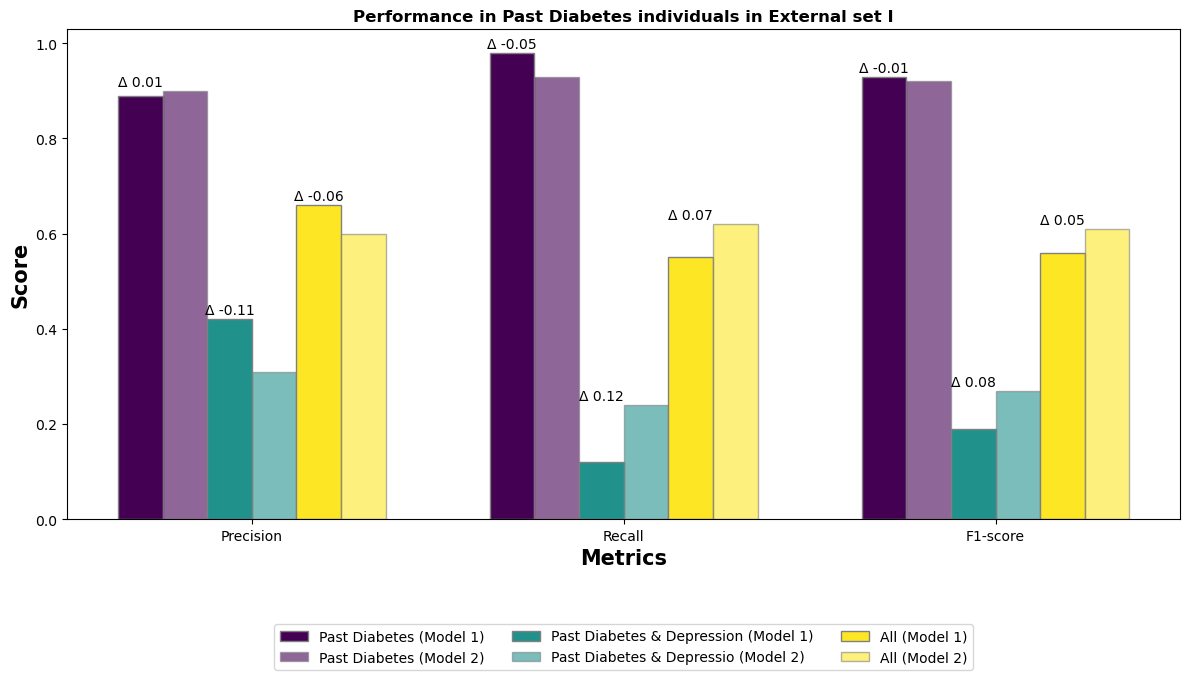

In [15]:
# Extract colors from the viridis colormap
colors = plt.cm.viridis(np.linspace(0, 1, 3))

# Data
x_labels = ['Precision', 'Recall', 'F1-score']

# Set width of bars
width = 0.12

# Create figure and axis objects
plt.figure(figsize=(12,7))

# Create bar positions
r1 = np.arange(len(x_labels))  # positions for the first dataset
r2 = [x + width for x in r1]  # positions for the second dataset
r3 = [x + width for x in r2]
r4 = [x + width for x in r3]
r5 = [x + width for x in r4]
r6 = [x + width for x in r5]

# Plot data
plt.bar(r1, Past, color=colors[0], width=width, edgecolor='grey', label='Past Diabetes (Model 1)')
plt.bar(r2, Past2, color=colors[0], width=width, edgecolor='grey', alpha=0.6, label='Past Diabetes (Model 2)')
plt.bar(r3, Depression, color=colors[1], width=width, edgecolor='grey', label='Past Diabetes & Depression (Model 1)')
plt.bar(r4, Depression2, color=colors[1], width=width, edgecolor='grey', alpha=0.6, label='Past Diabetes & Depressio (Model 2)')
plt.bar(r5, All, color=colors[2], width=width, edgecolor='grey', label='All (Model 1)')
plt.bar(r6, All2, color=colors[2], width=width, edgecolor='grey', alpha=0.6, label='All (Model 2)')

# Compute differences
diff_PastCVD = [a - b for a, b in zip(Past2, Past)]
diff_Depression = [a - b for a, b in zip(Depression2, Depression)]
diff_All = [a - b for a, b in zip(All2, All)]

# Displaying the differences on top of the bars
for i, diff in enumerate(diff_PastCVD):
    plt.text(r1[i], max(Past[i], Past2[i]) + 0.01, f"Δ {diff:.2f}", ha='center')
    
for i, diff in enumerate(diff_Depression):
    plt.text(r3[i], max(Depression[i], Depression2[i]) + 0.01, f"Δ {diff:.2f}", ha='center')
    
for i, diff in enumerate(diff_All):
    plt.text(r5[i], max(All[i], All2[i]) + 0.01, f"Δ {diff:.2f}", ha='center')


# Set axis labels and title
plt.xlabel('Metrics', fontweight='bold', fontsize=15)
plt.ylabel('Score', fontweight='bold', fontsize=15)

# Adjust x-ticks to be in the center of the grouped bars
plt.xticks([r + 2.5*width for r in range(len(Past))], x_labels)
plt.title('Performance in Past Diabetes individuals in External set I', fontweight='bold')

# Create the legend outside the figure at the bottom
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=len(x_labels))

# Adjust the layout to make room for the legend
plt.tight_layout()
plt.subplots_adjust(bottom=0.25)  # Adjust this value as needed

plt.savefig('Bar_Comparison_Corrected_Diabetes_I.png', dpi=300)
plt.show()

In [16]:
# Data
x_labels = ['Precision', 'Recall', 'F1-score']

PastCVD = [0.89, 0.99, 0.94]
Depression = [0.50, 0.10, 0.17]
All = [0.69, 0.54, 0.55]

PastCVD2 = [0.31, 0.24, 0.27]
Depression2 = [0.49, 0.60, 0.54]
All2 = [0.61, 0.59, 0.59]

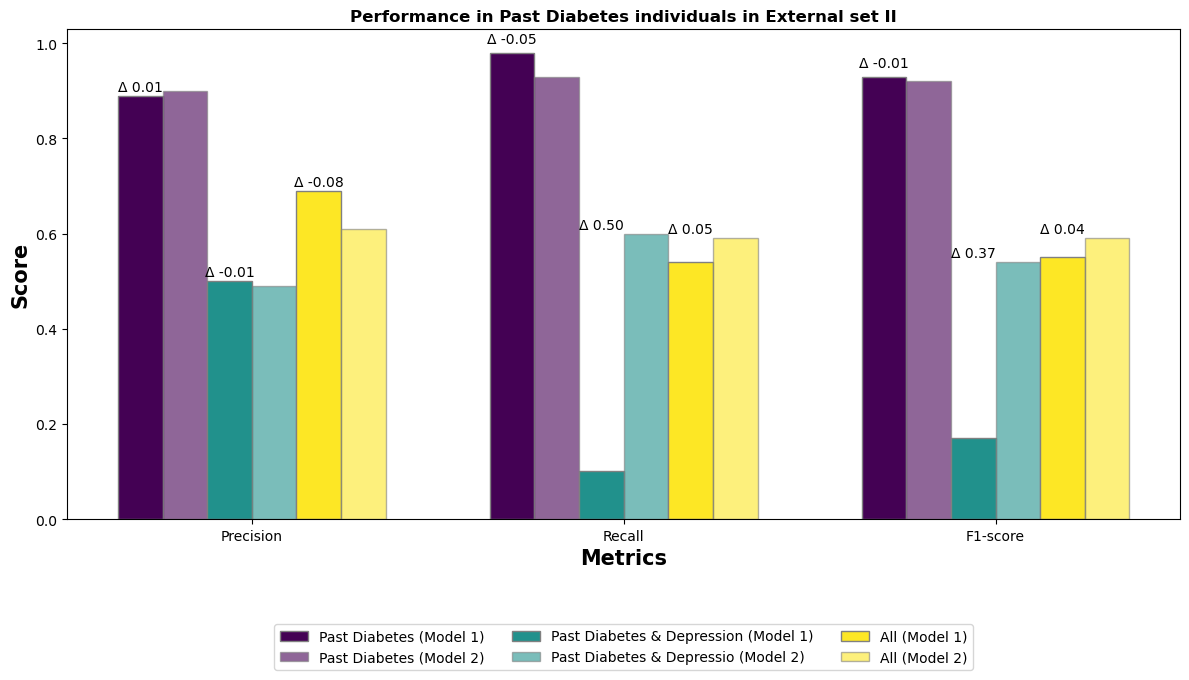

In [17]:
# Extract colors from the viridis colormap
colors = plt.cm.viridis(np.linspace(0, 1, 3))

# Data
x_labels = ['Precision', 'Recall', 'F1-score']

# Set width of bars
width = 0.12

# Create figure and axis objects
plt.figure(figsize=(12,7))

# Create bar positions
r1 = np.arange(len(x_labels))  # positions for the first dataset
r2 = [x + width for x in r1]  # positions for the second dataset
r3 = [x + width for x in r2]
r4 = [x + width for x in r3]
r5 = [x + width for x in r4]
r6 = [x + width for x in r5]

# Plot data
plt.bar(r1, Past, color=colors[0], width=width, edgecolor='grey', label='Past Diabetes (Model 1)')
plt.bar(r2, Past2, color=colors[0], width=width, edgecolor='grey', alpha=0.6, label='Past Diabetes (Model 2)')
plt.bar(r3, Depression, color=colors[1], width=width, edgecolor='grey', label='Past Diabetes & Depression (Model 1)')
plt.bar(r4, Depression2, color=colors[1], width=width, edgecolor='grey', alpha=0.6, label='Past Diabetes & Depressio (Model 2)')
plt.bar(r5, All, color=colors[2], width=width, edgecolor='grey', label='All (Model 1)')
plt.bar(r6, All2, color=colors[2], width=width, edgecolor='grey', alpha=0.6, label='All (Model 2)')

# Compute differences
diff_PastCVD = [a - b for a, b in zip(Past2, Past)]
diff_Depression = [a - b for a, b in zip(Depression2, Depression)]
diff_All = [a - b for a, b in zip(All2, All)]

# Displaying the differences on top of the bars
for i, diff in enumerate(diff_PastCVD):
    plt.text(r1[i], max(PastCVD[i], PastCVD2[i]) + 0.01, f"Δ {diff:.2f}", ha='center')
    
for i, diff in enumerate(diff_Depression):
    plt.text(r3[i], max(Depression[i], Depression2[i]) + 0.01, f"Δ {diff:.2f}", ha='center')
    
for i, diff in enumerate(diff_All):
    plt.text(r5[i], max(All[i], All2[i]) + 0.01, f"Δ {diff:.2f}", ha='center')


# Set axis labels and title
plt.xlabel('Metrics', fontweight='bold', fontsize=15)
plt.ylabel('Score', fontweight='bold', fontsize=15)

# Adjust x-ticks to be in the center of the grouped bars
plt.xticks([r + 2.5*width for r in range(len(PastCVD))], x_labels)
plt.title('Performance in Past Diabetes individuals in External set II', fontweight='bold')

# Create the legend outside the figure at the bottom
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=len(x_labels))

# Adjust the layout to make room for the legend
plt.tight_layout()
plt.subplots_adjust(bottom=0.25)  # Adjust this value as needed

plt.savefig('Bar_Comparison_Corrected_Diabetes_II.png', dpi=300)
plt.show()

In [18]:
PAT = '/Users/marinacamacho/Desktop/Master_I/Data_Final'
DIS = "Depression_1"
MOD = "Binary_1"
FET = "45"

In [19]:
with open(f"{PAT}/{MOD}/fitted_models_{DIS}{FET}", "rb") as fp:
    models = pickle.load(fp)

In [20]:
PAT = '/Users/marinacamacho/Desktop/Master_I/Data_Final'
DIS = "CVD_Depression_2"
MOD = "Binary_2"
FET = "45"

In [21]:
# Read trainCohort_{DIS} file
with open(f"{PAT}/trainCohort_{DIS}", "rb") as fp:
    trainData = pickle.load(fp)
# Read trainLabels_{DIS} file
with open(f"{PAT}/trainLabels_{DIS}", "rb") as fp:
    y_train = pickle.load(fp)

# Read externalCohort_{DIS} file
with open(f"{PAT}/externalCohort_{DIS}", "rb") as fp:
    extCohort = pickle.load(fp)
# Read externalLabels_{DIS} file
with open(f"{PAT}/externalLabels_{DIS}", "rb") as fp:
    y_ext = pickle.load(fp)

# Read traceCohort_{DIS} file
with open(f"{PAT}/traceCohort_{DIS}", "rb") as fp:
    traceCohort = pickle.load(fp)
# Read traceLabels_{DIS} file
with open(f"{PAT}/traceLabels_{DIS}", "rb") as fp:
    y_trace = pickle.load(fp)

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
import numpy as np

In [23]:
extCohort['PastCVD'] = 1
traceCohort['PastCVD'] = 1
trainData['PastCVD'] = 1

In [24]:
X_ext = extCohort.values
X_trace = traceCohort.values
X_train = trainData.values

In [25]:
# METRICS
# Classification
from sklearn.metrics import balanced_accuracy_score, average_precision_score, roc_auc_score, f1_score, recall_score, precision_score, classification_report
# Risk Prediction
from sklearn.metrics import brier_score_loss

In [26]:
# Sample datasets for demonstration
# Replace these with your actual datasets
dataset0_X, dataset0_y = X_train, y_train
dataset1_X, dataset1_y = X_ext, y_ext
dataset2_X, dataset2_y = X_trace, y_trace

results = {
    "Model": [],
    "Dataset": [],
    "Precision": [],
    "Recall": [],
    "F1-Score": [],
    "Balanced Accuracy": [],   # Add this line for Balanced Accuracy
}

for model_name, model_variants in models.items():
    for variant, model_info in model_variants.items():
        pipeline = model_info['model']
        threshold = model_info['threshold']
        
        #for dataset_name, (X, y) in [('Training set', (dataset0_X, dataset0_y)),('External set I', (dataset1_X, dataset1_y)), ('External set II', (dataset2_X, dataset2_y))]:
        for dataset_name, (X, y) in [('External set I', (dataset1_X, dataset1_y)), ('External set II', (dataset2_X, dataset2_y))]:
            # Obtain probabilities and predict based on the threshold
            y_prob = pipeline.predict_proba(X)[:, 1]
            y_pred = [1 if prob > threshold else 0 for prob in y_prob]

            report = classification_report(y, y_pred, output_dict=True, zero_division=0)

            # Balanced Accuracy
            bal_acc = balanced_accuracy_score(y, y_pred)

            # Assuming a binary classification, you can adjust as per your classes
            average_results = report['weighted avg']

            results["Model"].append(f"{model_name}_{variant}")
            results["Dataset"].append(dataset_name)
            results["Precision"].append(average_results['precision'])
            results["Recall"].append(average_results['recall'])
            results["F1-Score"].append(average_results['f1-score'])
            results["Balanced Accuracy"].append(bal_acc)  # Add this line to store Balanced Accuracy

df = pd.DataFrame(results)

# Display without truncation
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid featur

In [27]:
# Find the best model for Dataset1 based on F1-Score
best_model_idx_dataset1 = df[df['Dataset'] == 'External set I']['F1-Score'].idxmax()
best_model_info_dataset1 = df.loc[best_model_idx_dataset1]

print("Best Model for Dataset1 based on F1-Score:")
print(best_model_info_dataset1)
print("\n")  # just to create a gap between outputs

Best Model for Dataset1 based on F1-Score:
Model                XGB_3         
Dataset              External set I
Precision            0.873889      
Recall               0.906389      
F1-Score             0.882966      
Balanced Accuracy    0.549971      
Name: 26, dtype: object




In [28]:
best_model = models[best_model_info_dataset1[0][:-2]][int(best_model_info_dataset1[0][-1:])]
best_feats = trainData.iloc[:,best_model['features']].columns

probs = best_model['model'].predict_proba(X_ext)[:,1]
preds = np.where(probs > best_model['threshold'], 1, 0)
print(classification_report(y_true=y_ext,
                        y_pred=preds))

with open(f"{PAT}/{MOD}/best_model_ext{DIS}{FET}", "wb") as fp:
    pickle.dump(best_model, fp)

              precision    recall  f1-score   support

           0       0.92      0.98      0.95      5127
           1       0.39      0.12      0.18       492

    accuracy                           0.91      5619
   macro avg       0.65      0.55      0.57      5619
weighted avg       0.87      0.91      0.88      5619



/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(


In [29]:
probs = best_model['model'].predict_proba(X_trace)[:,1]
preds = np.where(probs > best_model['threshold'], 1, 0)
print(classification_report(y_true=y_trace,
                        y_pred=preds))

with open(f"{PAT}/{MOD}/best_model_trace{DIS}{FET}", "wb") as fp:
    pickle.dump(best_model, fp)

              precision    recall  f1-score   support

           0       0.93      1.00      0.96       633
           1       0.40      0.04      0.07        49

    accuracy                           0.93       682
   macro avg       0.67      0.52      0.52       682
weighted avg       0.89      0.93      0.90       682



/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(


In [30]:
# Data
x_labels = ['Precision', 'Recall', 'F1-score']

PastCVD = [0.92, 0.98, 0.95]
Depression = [0.39, 0.12, 0.18]
All = [0.65, 0.55, 0.57]

PastCVD2 = [0.93, 0.93, 0.92]
Depression2 = [0.26, 0.25, 0.25]
All2 = [0.59, 0.59, 0.59]

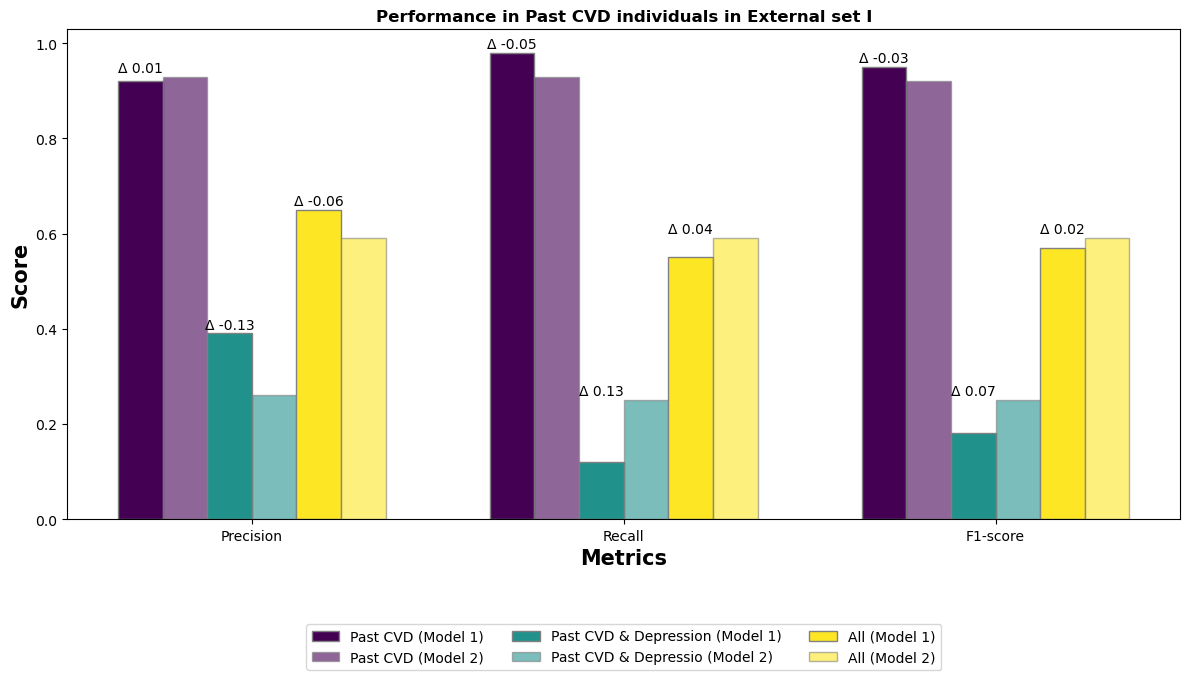

In [31]:
# Extract colors from the viridis colormap
colors = plt.cm.viridis(np.linspace(0, 1, 3))

# Data
x_labels = ['Precision', 'Recall', 'F1-score']

# Set width of bars
width = 0.12

# Create figure and axis objects
plt.figure(figsize=(12,7))

# Create bar positions
r1 = np.arange(len(x_labels))  # positions for the first dataset
r2 = [x + width for x in r1]  # positions for the second dataset
r3 = [x + width for x in r2]
r4 = [x + width for x in r3]
r5 = [x + width for x in r4]
r6 = [x + width for x in r5]

# Plot data
plt.bar(r1, PastCVD, color=colors[0], width=width, edgecolor='grey', label='Past CVD (Model 1)')
plt.bar(r2, PastCVD2, color=colors[0], width=width, edgecolor='grey', alpha=0.6, label='Past CVD (Model 2)')
plt.bar(r3, Depression, color=colors[1], width=width, edgecolor='grey', label='Past CVD & Depression (Model 1)')
plt.bar(r4, Depression2, color=colors[1], width=width, edgecolor='grey', alpha=0.6, label='Past CVD & Depressio (Model 2)')
plt.bar(r5, All, color=colors[2], width=width, edgecolor='grey', label='All (Model 1)')
plt.bar(r6, All2, color=colors[2], width=width, edgecolor='grey', alpha=0.6, label='All (Model 2)')

# Compute differences
diff_PastCVD = [a - b for a, b in zip(PastCVD2, PastCVD)]
diff_Depression = [a - b for a, b in zip(Depression2, Depression)]
diff_All = [a - b for a, b in zip(All2, All)]

# Displaying the differences on top of the bars
for i, diff in enumerate(diff_PastCVD):
    plt.text(r1[i], max(PastCVD[i], PastCVD2[i]) + 0.01, f"Δ {diff:.2f}", ha='center')
    
for i, diff in enumerate(diff_Depression):
    plt.text(r3[i], max(Depression[i], Depression2[i]) + 0.01, f"Δ {diff:.2f}", ha='center')
    
for i, diff in enumerate(diff_All):
    plt.text(r5[i], max(All[i], All2[i]) + 0.01, f"Δ {diff:.2f}", ha='center')


# Set axis labels and title
plt.xlabel('Metrics', fontweight='bold', fontsize=15)
plt.ylabel('Score', fontweight='bold', fontsize=15)

# Adjust x-ticks to be in the center of the grouped bars
plt.xticks([r + 2.5*width for r in range(len(PastCVD))], x_labels)
plt.title('Performance in Past CVD individuals in External set I', fontweight='bold')

# Create the legend outside the figure at the bottom
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=len(x_labels))

# Adjust the layout to make room for the legend
plt.tight_layout()
plt.subplots_adjust(bottom=0.25)  # Adjust this value as needed

plt.savefig('Bar_Comparison_Corrected_CVD_I.png', dpi=300)
plt.show()

In [32]:
# Data
x_labels = ['Precision', 'Recall', 'F1-score']

PastCVD = [0.92, 0.98, 0.95]
Depression = [0.39, 0.12, 0.18]
All = [0.65, 0.55, 0.57]

PastCVD2 = [0.94, 0.93, 0.92]
Depression2 = [0.25, 0.24, 0.25]
All2 = [0.60, 0.59, 0.59]

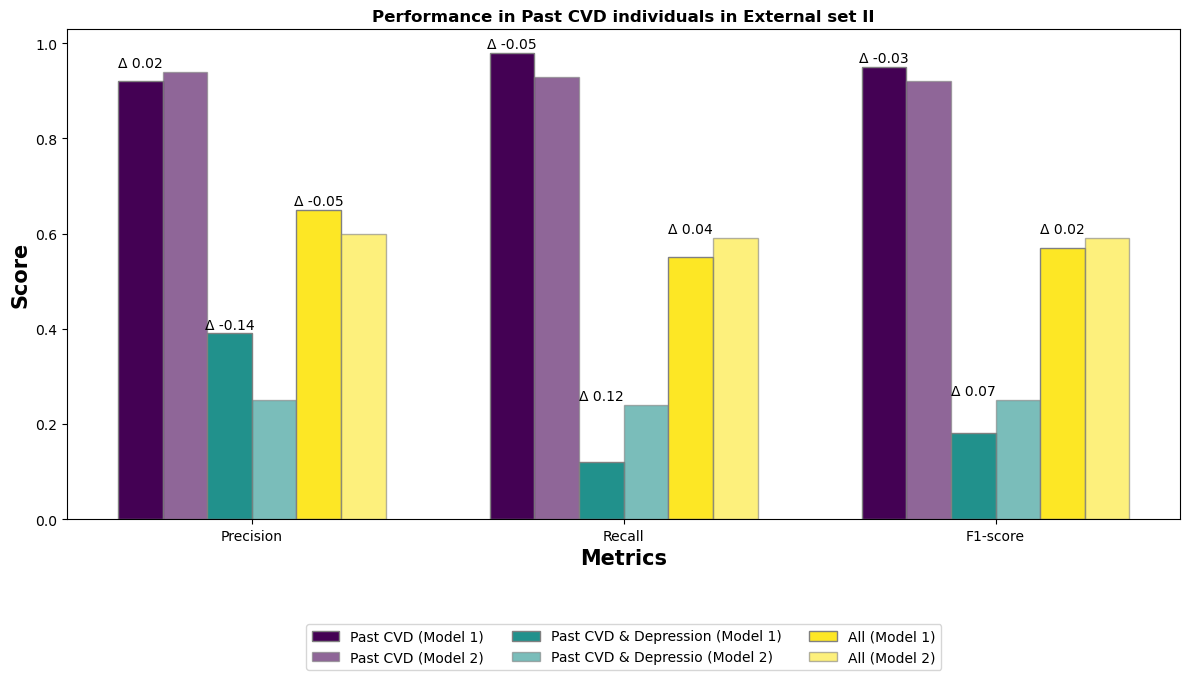

In [33]:
# Extract colors from the viridis colormap
colors = plt.cm.viridis(np.linspace(0, 1, 3))

# Data
x_labels = ['Precision', 'Recall', 'F1-score']

# Set width of bars
width = 0.12

# Create figure and axis objects
plt.figure(figsize=(12,7))

# Create bar positions
r1 = np.arange(len(x_labels))  # positions for the first dataset
r2 = [x + width for x in r1]  # positions for the second dataset
r3 = [x + width for x in r2]
r4 = [x + width for x in r3]
r5 = [x + width for x in r4]
r6 = [x + width for x in r5]

# Plot data
plt.bar(r1, PastCVD, color=colors[0], width=width, edgecolor='grey', label='Past CVD (Model 1)')
plt.bar(r2, PastCVD2, color=colors[0], width=width, edgecolor='grey', alpha=0.6, label='Past CVD (Model 2)')
plt.bar(r3, Depression, color=colors[1], width=width, edgecolor='grey', label='Past CVD & Depression (Model 1)')
plt.bar(r4, Depression2, color=colors[1], width=width, edgecolor='grey', alpha=0.6, label='Past CVD & Depressio (Model 2)')
plt.bar(r5, All, color=colors[2], width=width, edgecolor='grey', label='All (Model 1)')
plt.bar(r6, All2, color=colors[2], width=width, edgecolor='grey', alpha=0.6, label='All (Model 2)')

# Compute differences
diff_PastCVD = [a - b for a, b in zip(PastCVD2, PastCVD)]
diff_Depression = [a - b for a, b in zip(Depression2, Depression)]
diff_All = [a - b for a, b in zip(All2, All)]

# Displaying the differences on top of the bars
for i, diff in enumerate(diff_PastCVD):
    plt.text(r1[i], max(PastCVD[i], PastCVD2[i]) + 0.01, f"Δ {diff:.2f}", ha='center')
    
for i, diff in enumerate(diff_Depression):
    plt.text(r3[i], max(Depression[i], Depression2[i]) + 0.01, f"Δ {diff:.2f}", ha='center')
    
for i, diff in enumerate(diff_All):
    plt.text(r5[i], max(All[i], All2[i]) + 0.01, f"Δ {diff:.2f}", ha='center')


# Set axis labels and title
plt.xlabel('Metrics', fontweight='bold', fontsize=15)
plt.ylabel('Score', fontweight='bold', fontsize=15)

# Adjust x-ticks to be in the center of the grouped bars
plt.xticks([r + 2.5*width for r in range(len(PastCVD))], x_labels)
plt.title('Performance in Past CVD individuals in External set II', fontweight='bold')

# Create the legend outside the figure at the bottom
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=len(x_labels))

# Adjust the layout to make room for the legend
plt.tight_layout()
plt.subplots_adjust(bottom=0.25)  # Adjust this value as needed

plt.savefig('Bar_Comparison_Corrected_CVD_II.png', dpi=300)
plt.show()


